# Imports & Options

In [4]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr.crispr_class import Crispr
import celltypist
import pertpy as pt
import pandas as pd
import numpy as np
from config import (
    files_data, assays_data, col_cell_type_data, col_gene_symbols_data,
    col_perturbation_data, key_control_data, key_treatment_data,
    col_target_genes_data, col_split_by_data, 
    col_batch_data, col_sample_id_data, 
    kws_process_guide_rna_data, col_guide_rna_data, col_num_umis_data)

# Options
pd.options.display.max_columns = 100
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
file = "CRISPRi_scr"
# file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"
kws_pca = dict(n_comps=None, use_highly_variable=True)
kws_neighbors = None  # passed to neighbors function
kws_umap = dict(min_dist=0.3)  # passed to UMAP fx
kws_cluster = dict(resolution=0.5)  # passed to louvain/leiden fx

#  Set Arguments
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
file_path = files_data[file]
col_split_by = col_split_by_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols_data[file],  
                   col_cell_type=col_cell_type_data[file], 
                   col_sample_id=col_sample_id_data[file], 
                   col_batch=col_batch_data[file],
                   col_perturbation=col_perturbation_data[file], 
                   col_guide_rna=col_guide_rna_data[file], 
                   col_num_umis=col_num_umis_data[file],
                   kws_process_guide_rna=kws_process_guide_rna_data[file],
                   col_target_genes=col_target_genes_data[file], 
                   key_control=key_control_data[file], 
                   key_treatment=key_treatment_data[file],
                   remove_multi_transfected=True)
print(files_data)
if file == "default_fast":
    skip_preprocessing_clustering = True
print("\n\n\nInitialization keyword arguments:\n", kwargs_init)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'find_markers', 'perform_augur', 'perform_differential_prioritization', 'perform_gsea', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH03'}, 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/asline01/projects/crispr/examples/data/dixit_2016_raw.h5ad', 'perturb-seq': '/home/asline01/projects/crispr/examples/data/adamson_2016_upr_pert

# Setup Object

## Instantiate


This is more code than an end-user will actually need. `self = Crispr(file_path)` is the bare minimum needed (though you must specify some column and entry label names, such as the column name for the gene symbols, if they aren't the same as the defaults).

End users can simply pass to the `file` argument of `Crispr()` a 10x CellRanger output directory (or a dictionary of appropriate protospacer-related arguments if perturbation-related data aren't included in the .mtx file; see the `Crispr.preprocessing.combine_matrix_protospacer()` function for details) or .h5ad file if desired.

The extra code is just for generalizability across example datasets because in certain cases, we want to pass an AnnData Scanpy object because there are specific manipulations made to certain public datasets in the `config.load_example_data`` function meant to decrease computation time/memory usage, etc.


In [31]:
print(f"Initialization arguments (from config):\n\n{kwargs_init}")
if isinstance(file, str) and file in ["ECCITE", "Adamson"]:
    self = Crispr(
        pt.data.papalexi_2021() if file == "ECCITE" else
        pt.data.adamson_2016_upr_perturb_seq(), **kwargs_init)
else:
    self = Crispr(file_path, **kwargs_init)
self.adata[self._assay].obs if self._assay else self.adata.obs

Initialization arguments (from config):

{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'kws_process_guide_rna': {'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL']}, 'col_target_genes': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'KD', 'remove_multi_transfected': True}


<<<INITIALIZING CRISPR CLASS OBJECT>>>



# Preprocess and Cluster

See `self.figures[run_label]["clustering"]` (object attribute) or method output for figures.

You must set use_highly_variable to False if you don't want to filter by HVGs
and if you did not set kws_hvg to None or False in `.preprocess()`


In that scenario, the 'highly_variable' column in  will be created in `.obsm` 
during `.preprocess()` and then used by default in `.cluster`.

UMAP Keywords: {'min_dist': 0.3}
AnnData object with n_obs × n_vars = 6733 × 22024
    obs: 'num_features', 'feature_call_original', 'num_umis_original', 'feature_call', 'feature_call_flat_ix', 'feature_call_list_all', 'num_umis_list_all', 'num_umis_total', 'feature_call_list_filtered', 'num_umis_list_filtered', 'feature_call_filtered', 'num_umis_filtered', 'feature_split', 'num_umis', 'target_gene_name', 'perturbation', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_original'
    obsp: 'distances', 'connectivities'


Cell Counts


leiden
0    1152
1    1087
2    1010
3     9

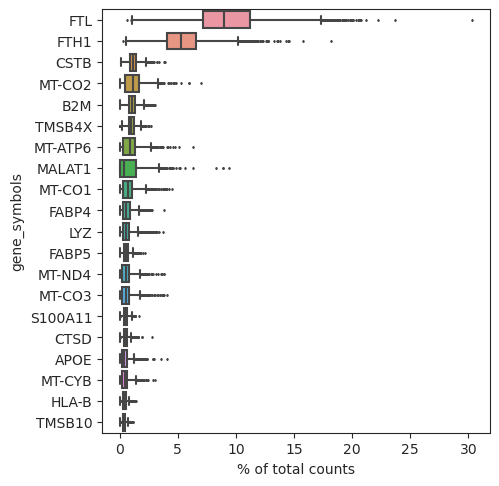


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


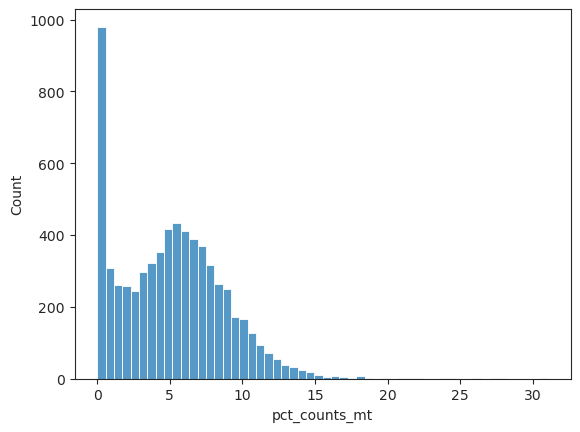

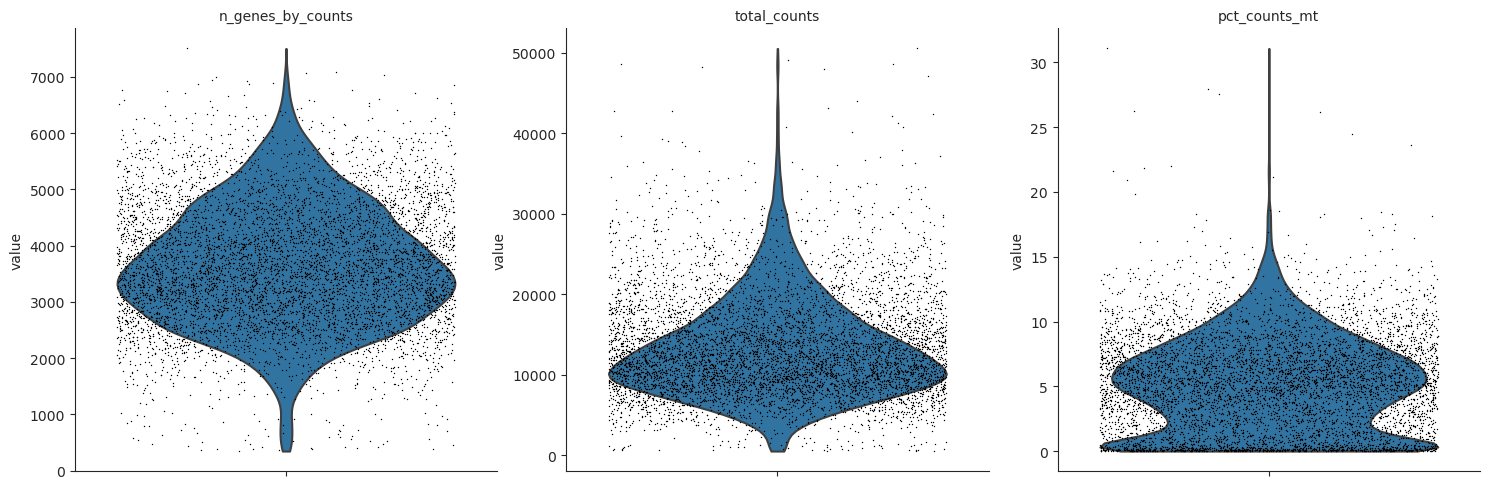

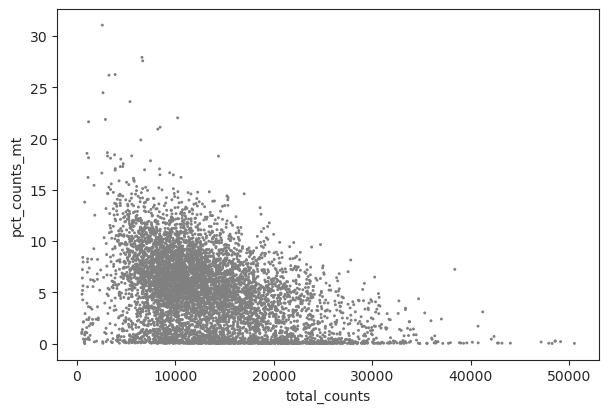

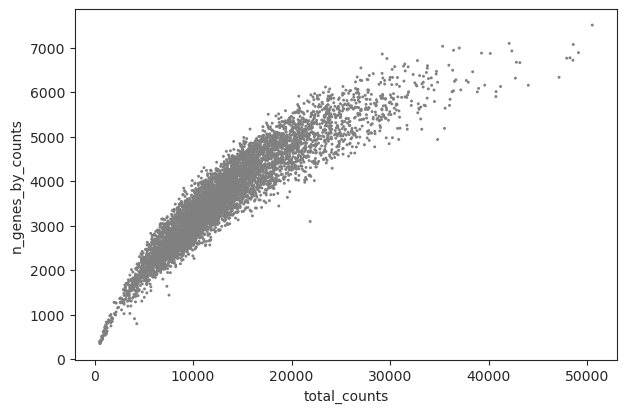


<<< NORMALIZING >>>


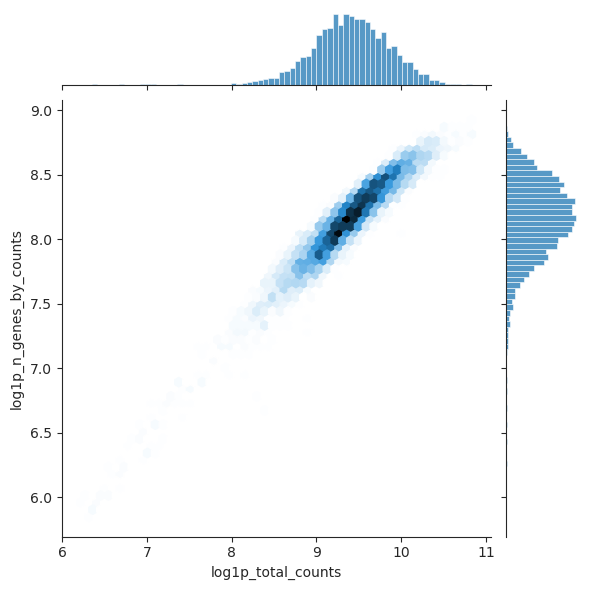

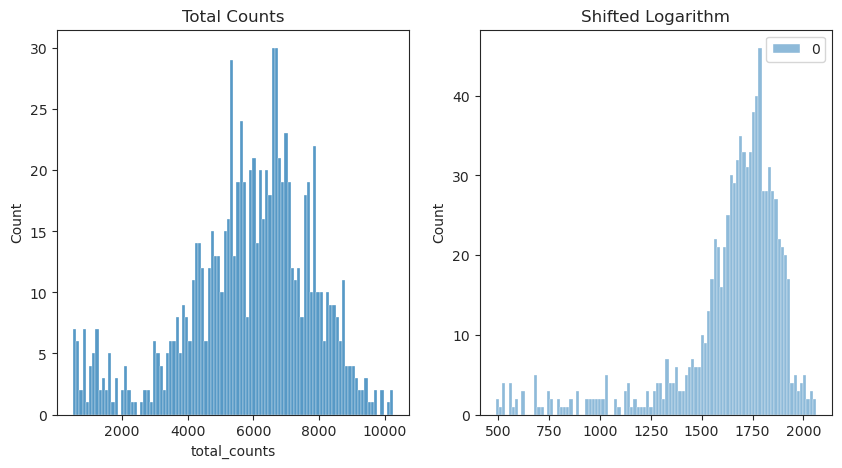


<<< DETECTING VARIABLE GENES >>>

<<< SCALING >>>


Cell Counts (Post-Processing)


leiden
1    476
3    236
8     87
6     63
0     18
2     12
4      5
Name: count, dtype: int64



Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'col_target_genes': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': False}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>


<<< EMBEDDING: UMAP >>>

 {'min_dist': 0.3}


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


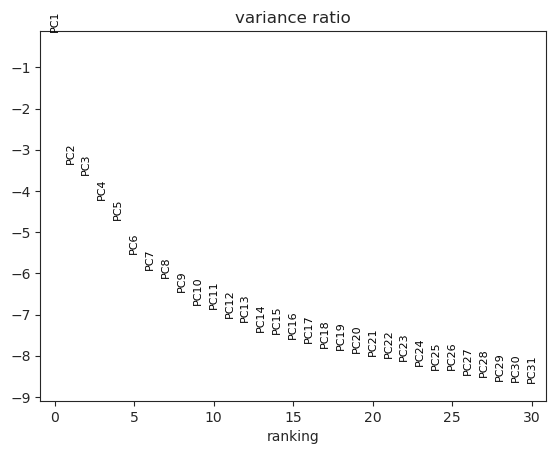

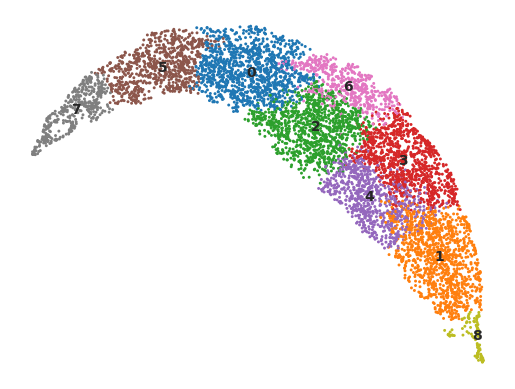

num_features  \
AAACCCAAGATTTGCC-1           2.0   
AAACCCAAGCGATTCT-1           3.0   
AAACCCAAGTCTGCAT-1           6.0   
AAACCCACAGGATCTT-1           9.0   
AAACCCAGTCTCAAGT-1           1.0   
...                          ...   
TTTGTTGAGGTGCAGT-1           2.0   
TTTGTTGAGTACTCGT-1           4.0   
TTTGTTGGTTGCCGAC-1           4.0   
TTTGTTGTCACTGTTT-1           2.0   
TTTGTTGTCAGTGTGT-1           5.0   

                                                feature_call_original  \
AAACCCAAGATTTGCC-1                                    SNX17-1|SNX17-2   
AAACCCAAGCGATTCT-1                           SP110-1|HLA-B-1|SP140L-2   
AAACCCAAGTCTGCAT-1    RSBN1-1|PRDX6-1|STK11-1|RSBN1-2|PRDX6-2|NR4A1-2   
AAACCCACAGGATCTT-1  TAGAP-1|CRYZL1-1|MYD88-1|NR4A1-1|SPI1-1|IFNAR2...   
AAACCCAGTCTCAAGT-1                                             SPI1-2   
...                                                               ...   
TTTGTTGAGGTGCAGT-1                                    FASLG-1|FASLG-2   
TTTGTTGAGTACTCGT-1                POLR2E-1|IFNGR2-1|POLR2E-2|IFNGR2-2   
TTTGTTGGTTGCCGAC-1                    DUSP1-1|PPARA-1|TAGAP-2|DUSP1-2   
TTTGTTGTCACTGTTT-1                                   ATG16L1-1|GPX4-1   
TTTGTTGTCAGTGTGT-1       HLA-B-1|TMEM50B-1|DUSP1-1|DUSP1-2|RUNX3-P2-2   

                              num_umis_original feature_call  \
AAACCCAAGATTTGCC-1                       200|33        SNX17   
AAACCCAAGCGATTCT-1                      12|22|7          HLA   
AAACCCAAGTCTGCAT-1        194|381|51|513|119|47        RSBN1   
AAACCCACAGGATCTT-1  378|47|29|503|9|41|84|26|84        NR4A1   
AAACCCAGTCTCAAGT-1                           11         SPI1   
...                                         ...          ...   
TTTGTTGAGGTGCAGT-1                        58|41        FASLG   
TTTGTTGAGTACTCGT-1              681|216|146|143       POLR2E   
TTTGTTGGTTGCCGAC-1                   48|19|4|46        DUSP1   
TTTGTTGTCACTGTTT-1                       73|125         GPX4   
TTTGTTGTCAGTGTGT-1              188|168|35|9|47          HLA   

                                                 feature_call_flat_ix  \
AAACCCAAGATTTGCC-1                                          SNX17-1_2   
AAACCCAAGCGATTCT-1                           SP110-1|HLA-B-1|SP140L-2   
AAACCCAAGTCTGCAT-1                RSBN1-1_2|PRDX6-1_2|STK11-1|NR4A1-2   
AAACCCACAGGATCTT-1  TAGAP-1|CRYZL1-1_2|MYD88-1|NR4A1-1_2|SPI1-1|IF...   
AAACCCAGTCTCAAGT-1                                             SPI1-2   
...                                                               ...   
TTTGTTGAGGTGCAGT-1                                          FASLG-1_2   
TTTGTTGAGTACTCGT-1                              POLR2E-1_2|IFNGR2-1_2   
TTTGTTGGTTGCCGAC-1                          DUSP1-1_2|PPARA-1|TAGAP-2   
TTTGTTGTCACTGTTT-1                                   ATG16L1-1|GPX4-1   
TTTGTTGTCAGTGTGT-1             HLA-B-1|TMEM50B-1|DUSP1-1_2|RUNX3-P2-2   

                                                feature_call_list_all  \
AAACCCAAGATTTGCC-1                                     [SNX17, SNX17]   
AAACCCAAGCGATTCT-1                               [SP110, HLA, SP140L]   
AAACCCAAGTCTGCAT-1         [RSBN1, PRDX6, STK11, RSBN1, PRDX6, NR4A1]   
AAACCCACAGGATCTT-1  [TAGAP, CRYZL1, MYD88, NR4A1, SPI1, IFNAR2, IL...   
AAACCCAGTCTCAAGT-1                                             [SPI1]   
...                                                               ...   
TTTGTTGAGGTGCAGT-1                                     [FASLG, FASLG]   
TTTGTTGAGTACTCGT-1                   [POLR2E, IFNGR2, POLR2E, IFNGR2]   
TTTGTTGGTTGCCGAC-1                       [DUSP1, PPARA, TAGAP, DUSP1]   
TTTGTTGTCACTGTTT-1                                    [ATG16L1, GPX4]   
TTTGTTGTCAGTGTGT-1                [HLA, TMEM50B, DUSP1, DUSP1, RUNX3]   

                                                    num_umis_list_all  \
AAACCCAAGATTTGCC-1                                      [200.0, 33.0]   
AAACCCAAGCGATTCT-1                       

In [29]:
if skip_preprocessing_clustering is False:  # if not already processed & clustered
    
    # Arguments
    print(f"UMAP Keywords: {kws_umap}")
    
    # Preprocess
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                       target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=15,
                       min_genes=200, min_cells=3, scale=10, regress_out=None)
    self.preprocess(**process_kws, kws_umap=kws_umap)  # preprocessing
    
    # Cluster 
    self.cluster(method_cluster="leiden", kws_neighbors=kws_neighbors,
                 kws_pca=kws_pca, kws_umap=kws_umap,  kws_cluster=kws_cluster)
    
self.adata.obs

### CellTypist Cell Cluster Annotation

You can see what models are available with this code:
```
import celltypist
celltypist.models.models_description().set_index("model").description.apply(lambda x: print(x))
celltypist.models.models_description()
```

Or it will do it for you automatically if you feed it an unknown model:

```
self.annotate_clusters(model="kate_moss.pkl")
```

In [30]:
self.adata.raw

In [23]:
# import celltypist 
# celltypist.models.download_models()
preds = self.annotate_clusters(model="COVID19_HumanChallenge_Blood.pkl")

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will try the `.raw` attribute


Exception: 🛑 Fail to use the `.raw` attribute in the input object. 'NoneType' object has no attribute 'X'

### Find Cluster Markers (DEGs)

To sort by absolute values on "scores" for cluster 6, showing the top 3 gene markers:

`clus = "6"`

`marks.loc[clus].loc[marks.loc[clus].scores.abs().sort_values(ascending=False).iloc[:3].index]`

To show the top 3 gene markers for all clusters:

`marks.groupby(marks.index.names[0]).apply(lambda x: x.scores.abs().sort_values(ascending=False).iloc[:3].index])`

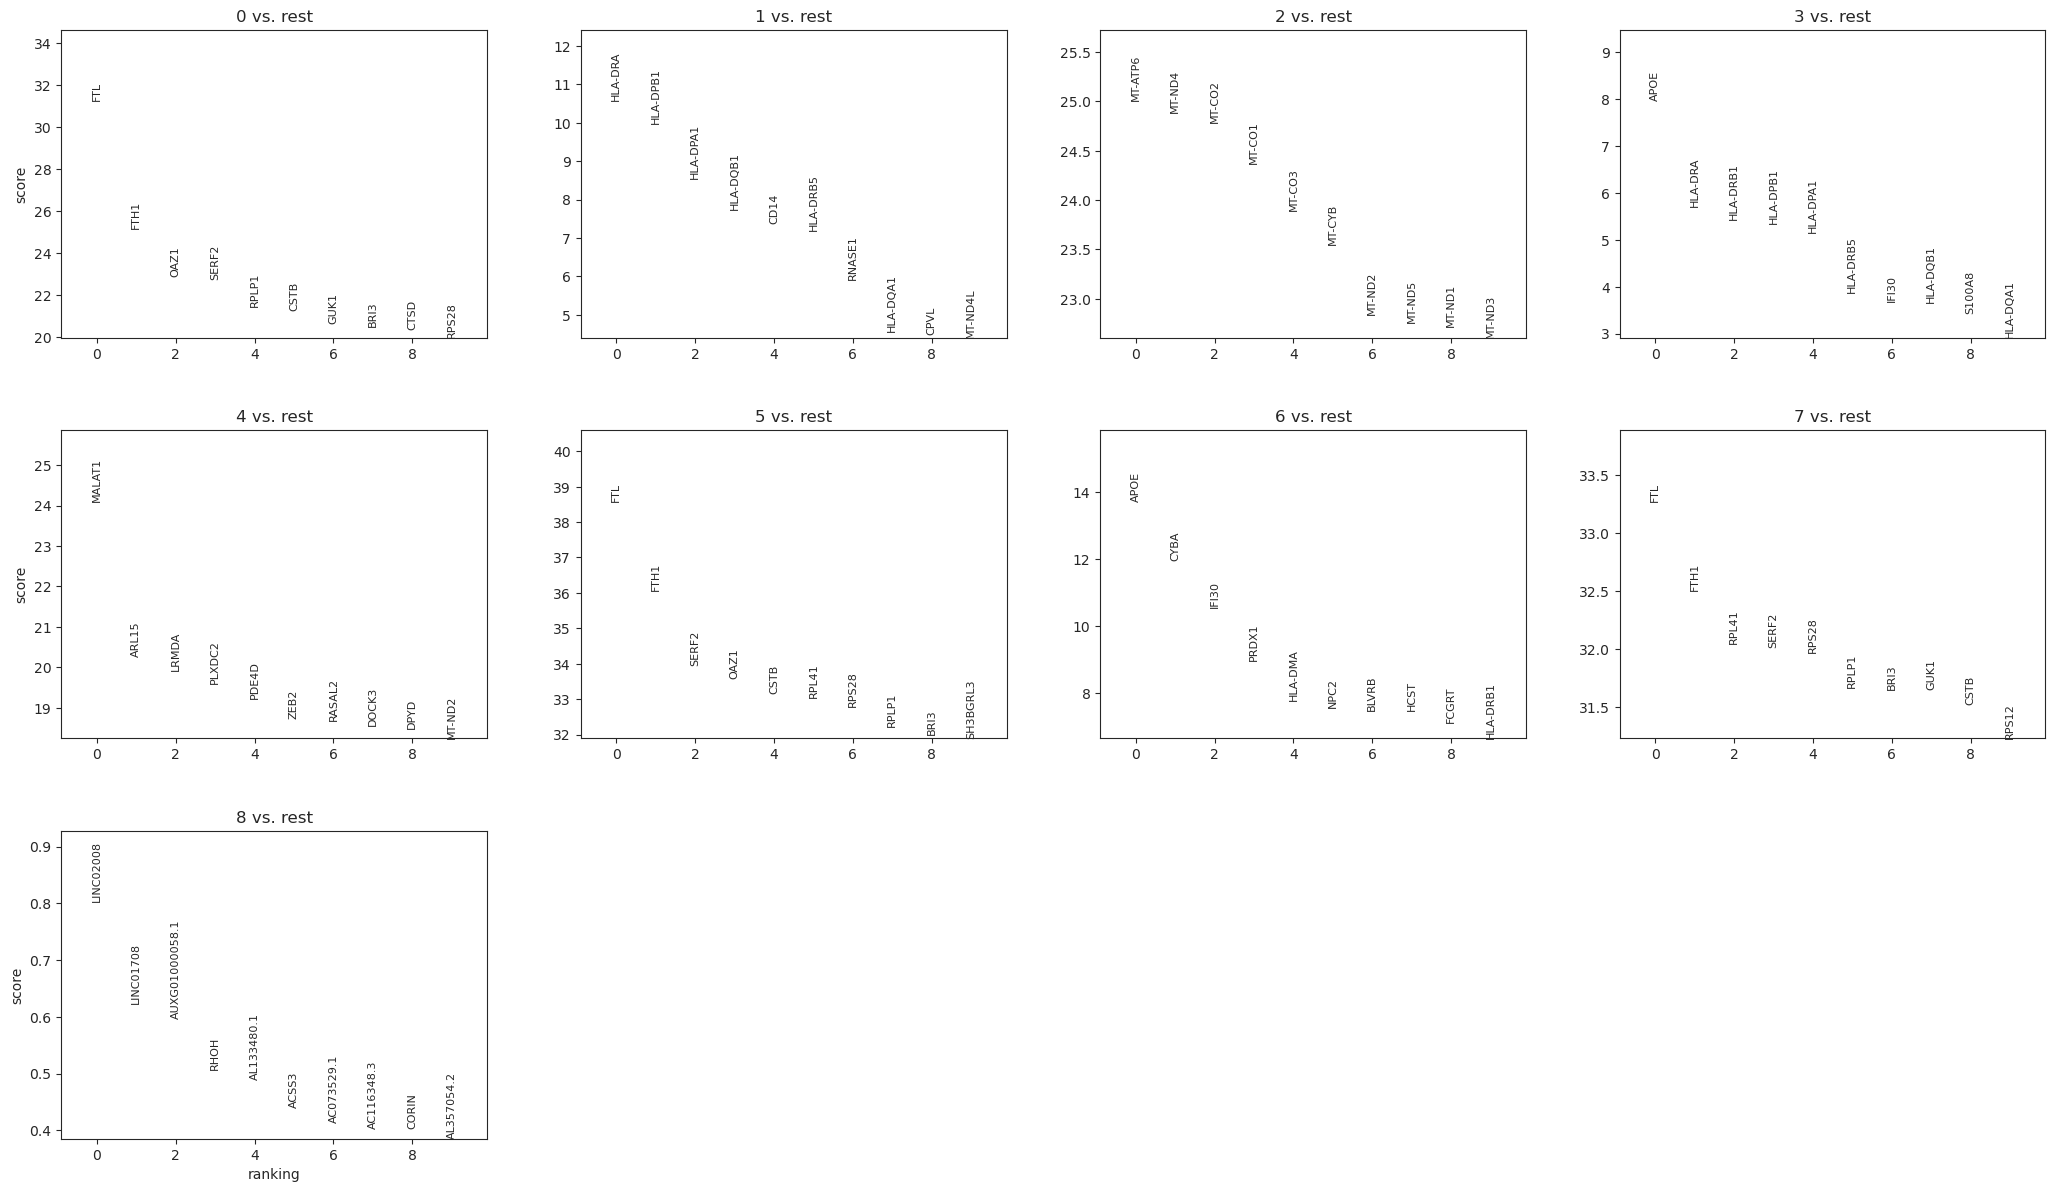

                  scores  logfoldchanges          pvals      pvals_adj
leiden names                                                          
0      FTL     31.232216             NaN  3.893431e-214  8.574892e-210
       FTH1    25.160320             inf  1.089610e-139  1.199879e-135
       OAZ1    22.877329       11.322585  7.814102e-116  5.736593e-112
       SERF2   22.725088       15.650467  2.531195e-114  1.393676e-110
       RPLP1   21.440582        9.388279  5.590880e-102   2.462671e-98
...                  ...             ...            ...            ...
8      BRI3   -17.566845      -36.268684   4.420866e-69   1.681593e-65
       TYROBP -17.577623      -47.757553   3.655761e-69   1.681593e-65
       TMSB4X -17.587805     -164.059311   3.054830e-69   1.681593e-65
       FTH1   -17.765842            -inf   1.299722e-70   1.431254e-66
       FTL    -17.807613            -inf   6.168356e-71   1.358519e-66

[198216 rows x 4 columns]


scores  logfoldchanges          pvals      pvals_adj
leiden names                                                          
0      FTL     31.232216             NaN  3.893431e-214  8.574892e-210
       FTH1    25.160320             inf  1.089610e-139  1.199879e-135
       OAZ1    22.877329       11.322585  7.814102e-116  5.736593e-112
       SERF2   22.725088       15.650467  2.531195e-114  1.393676e-110
       RPLP1   21.440582        9.388279  5.590880e-102   2.462671e-98
...                  ...             ...            ...            ...
8      BRI3   -17.566845      -36.268684   4.420866e-69   1.681593e-65
       TYROBP -17.577623      -47.757553   3.655761e-69   1.681593e-65
       TMSB4X -17.587805     -164.059311   3.054830e-69   1.681593e-65
       FTH1   -17.765842            -inf   1.299722e-70   1.431254e-66
       FTL    -17.807613            -inf   6.168356e-71   1.358519e-66

[198216 rows x 4 columns]

In [4]:
marks, figs_m = self.find_markers(n_genes=10, layer="scaled", use_raw=False,
                                  method="wilcoxon", key_reference="rest")
marks

## Inspect & Prepare

## Explore Data Descriptives




        num_features  num_umis_total  n_genes  n_genes_by_counts  \
count       6733.00         6733.00  6733.00            6733.00   
mean           3.68          689.34  3615.72            3615.01   
std            2.60          873.72  1066.72            1066.29   
min            1.00            4.00   346.00             346.00   
25%            2.00          140.00  2865.00            2865.00   
50%            3.00          402.00  3538.00            3537.00   
75%            5.00          904.00  4334.00            4334.00   
max           25.00        12124.00  7510.00            7505.00   

       log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
count                  6733.00       6733.00             6733.00   
mean                      8.14      13228.58                9.38   
std                       0.34       6178.28                0.51   
min                       5.85        504.00                6.22   
25%                       7.96       9008.00        

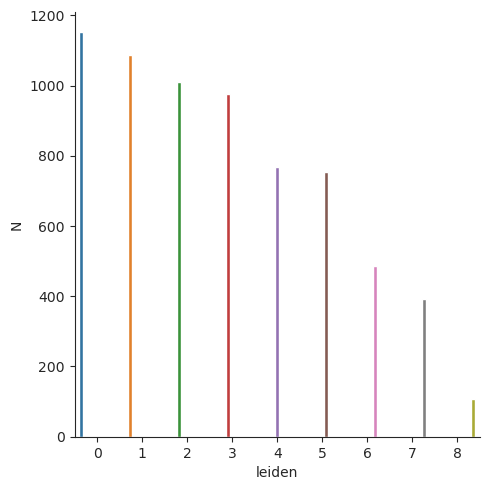

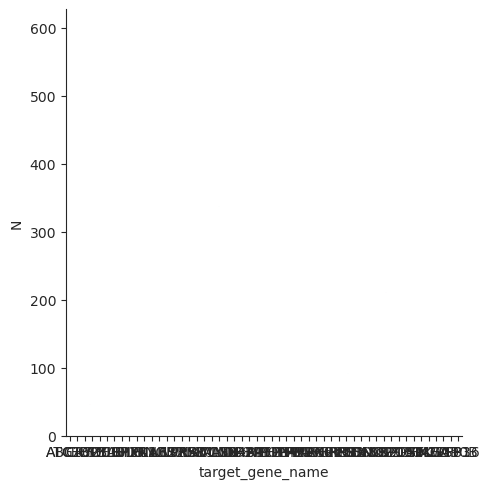

In [5]:
# self.describe()  # simple
figs = self.describe(group_by=self._columns["col_target_genes"], plot=True)

## Set Up Arguments for Later


This code looks more complicated than it actually would actually be for an end user because it was made to be generalizable across several datasets with particular column names, sizes that make it necessary to subset them in order to run the vignettes in a reasonable period of time, etc.

Basically, you won't need this code as an end user; this is just to choose relevant random subsets of genes, perturbations, etc. that are available in a given example dataset, for illustration purposes (and to conserve memory/time by not using every gene/condition/etc.). 

In real use cases, you will know what genes and conditions are of interest, and you can manually specify them by simply stating them in the appropriate arguments (such as `target_gene_idents`) or (in many cases) by not specifying the argument (resulting in the code using all available genes, etc.).

In [4]:
# Choose Subset of Sequenced Genes
genes = np.array((self.adata[assay] if assay else self.adata.var.reset_index(
    ))[self._columns["col_gene_symbols"]])
if file == "CRISPRi_scr":
    genes_subset = ["CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A", 
                    "CXCL8", "CCL2", "CEBPB", "NFKB1", "IGFBP7", "TGFB1", 
                    "BCL2", "PTGER4", "ERCC1", "ERCC4", "ATG16L1", "NOD2", "LACC1"]
else:
    genes_subset = list(pd.Series(genes).sample(10))
target_gene_idents = list(self.adata.obs[self._columns[
    "col_target_genes"]].sample(10))  # guide targets

# Perturbation Categories
(self.adata[assay] if assay else self.adata).obs[
    self._columns["col_perturbation"]].unique()

['KD', 'NT']
Categories (2, object): ['KD', 'NT']

# Initial Plots

## Basic Usage

In [ ]:
figs = self.plot(genes=genes_subset)

## Advanced Usage

Use the `layers` argument to plot more layers (in this instance, all of them, including the scaled data) for certain plot types.
 
Use the `cell_types_circle` argument to create a UMAP with certain cell types circled in red.

Use the `genes_highlight` argument to highlight in gold the names of specified genes on the gene expression dot plot.

Use the `kws_clustering` argument to specify a dictionary keywords to pass to certain UMAP-based plots. For instance, specify `kws_clustering=dict(col_cell_type="leiden")` to use leiden clusters instead of whatever is stored in `self._columns["col_cell_type"]`.

Use the `kws_gex_violin` argument to pass additional arguments to the violin plots of gene expression.


<<< PLOTTING PRE-PROCESSING >>>

<<< PLOTTING GEX (Heatmap) >>>

<<< PLOTTING GEX (Violin) >>>


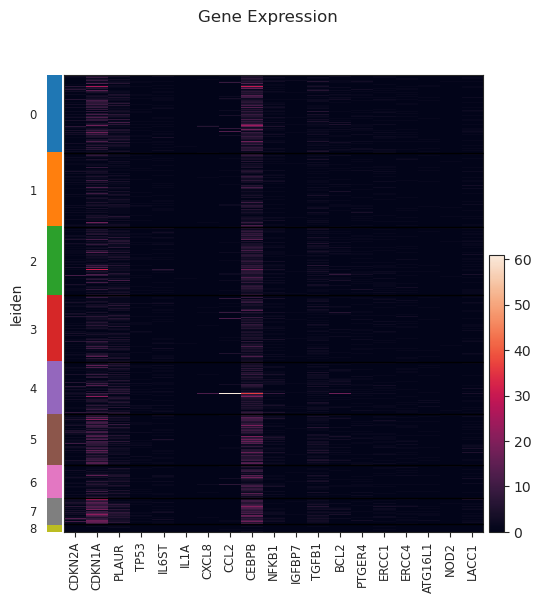

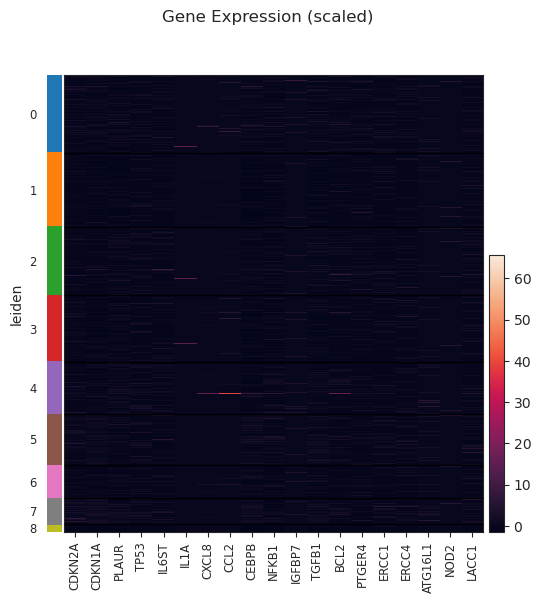

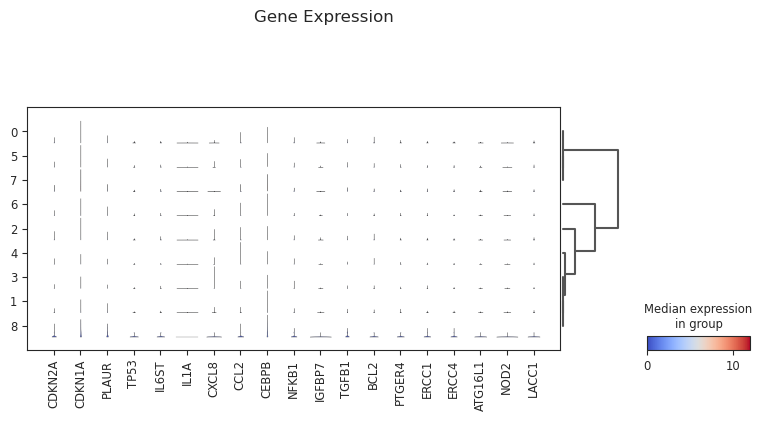

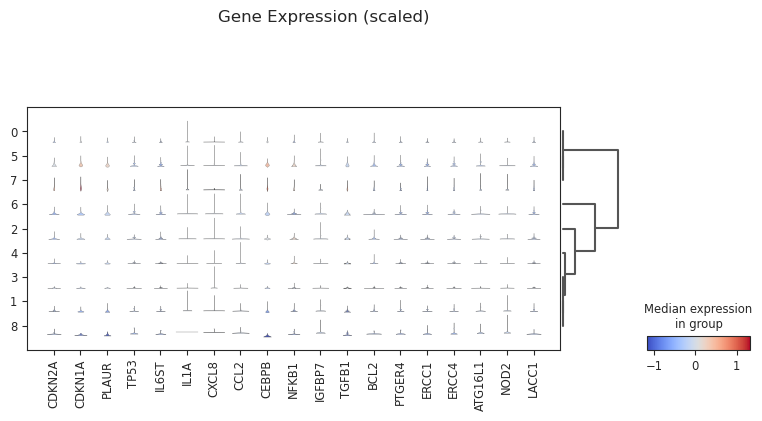


<<< PLOTTING GEX (Matrix) >>>
{'cmap': 'coolwarm', 'dendrogram': True, 'swap_axes': False}


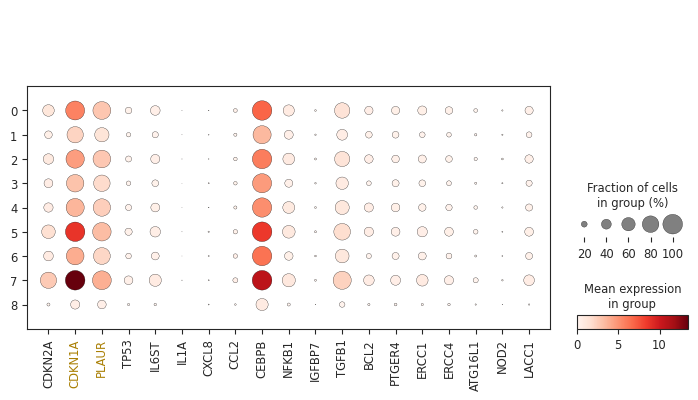

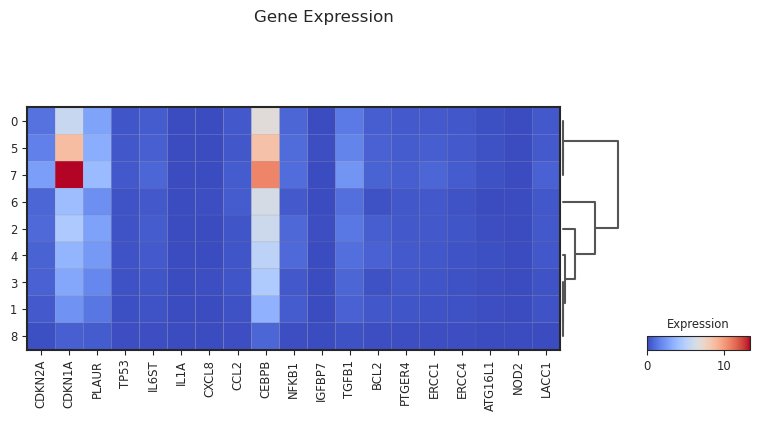

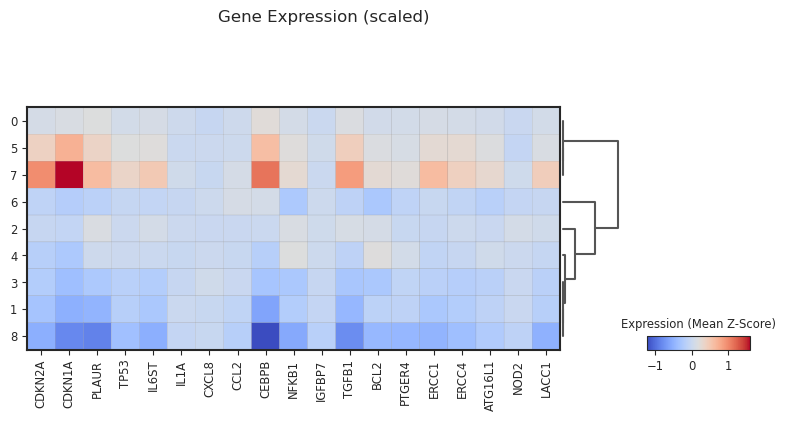


<<< PLOTTING UMAP >>>

<<< PLOTTING GEX ON UMAP >>>


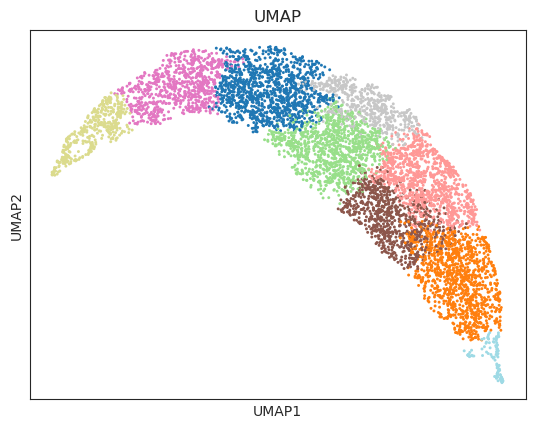

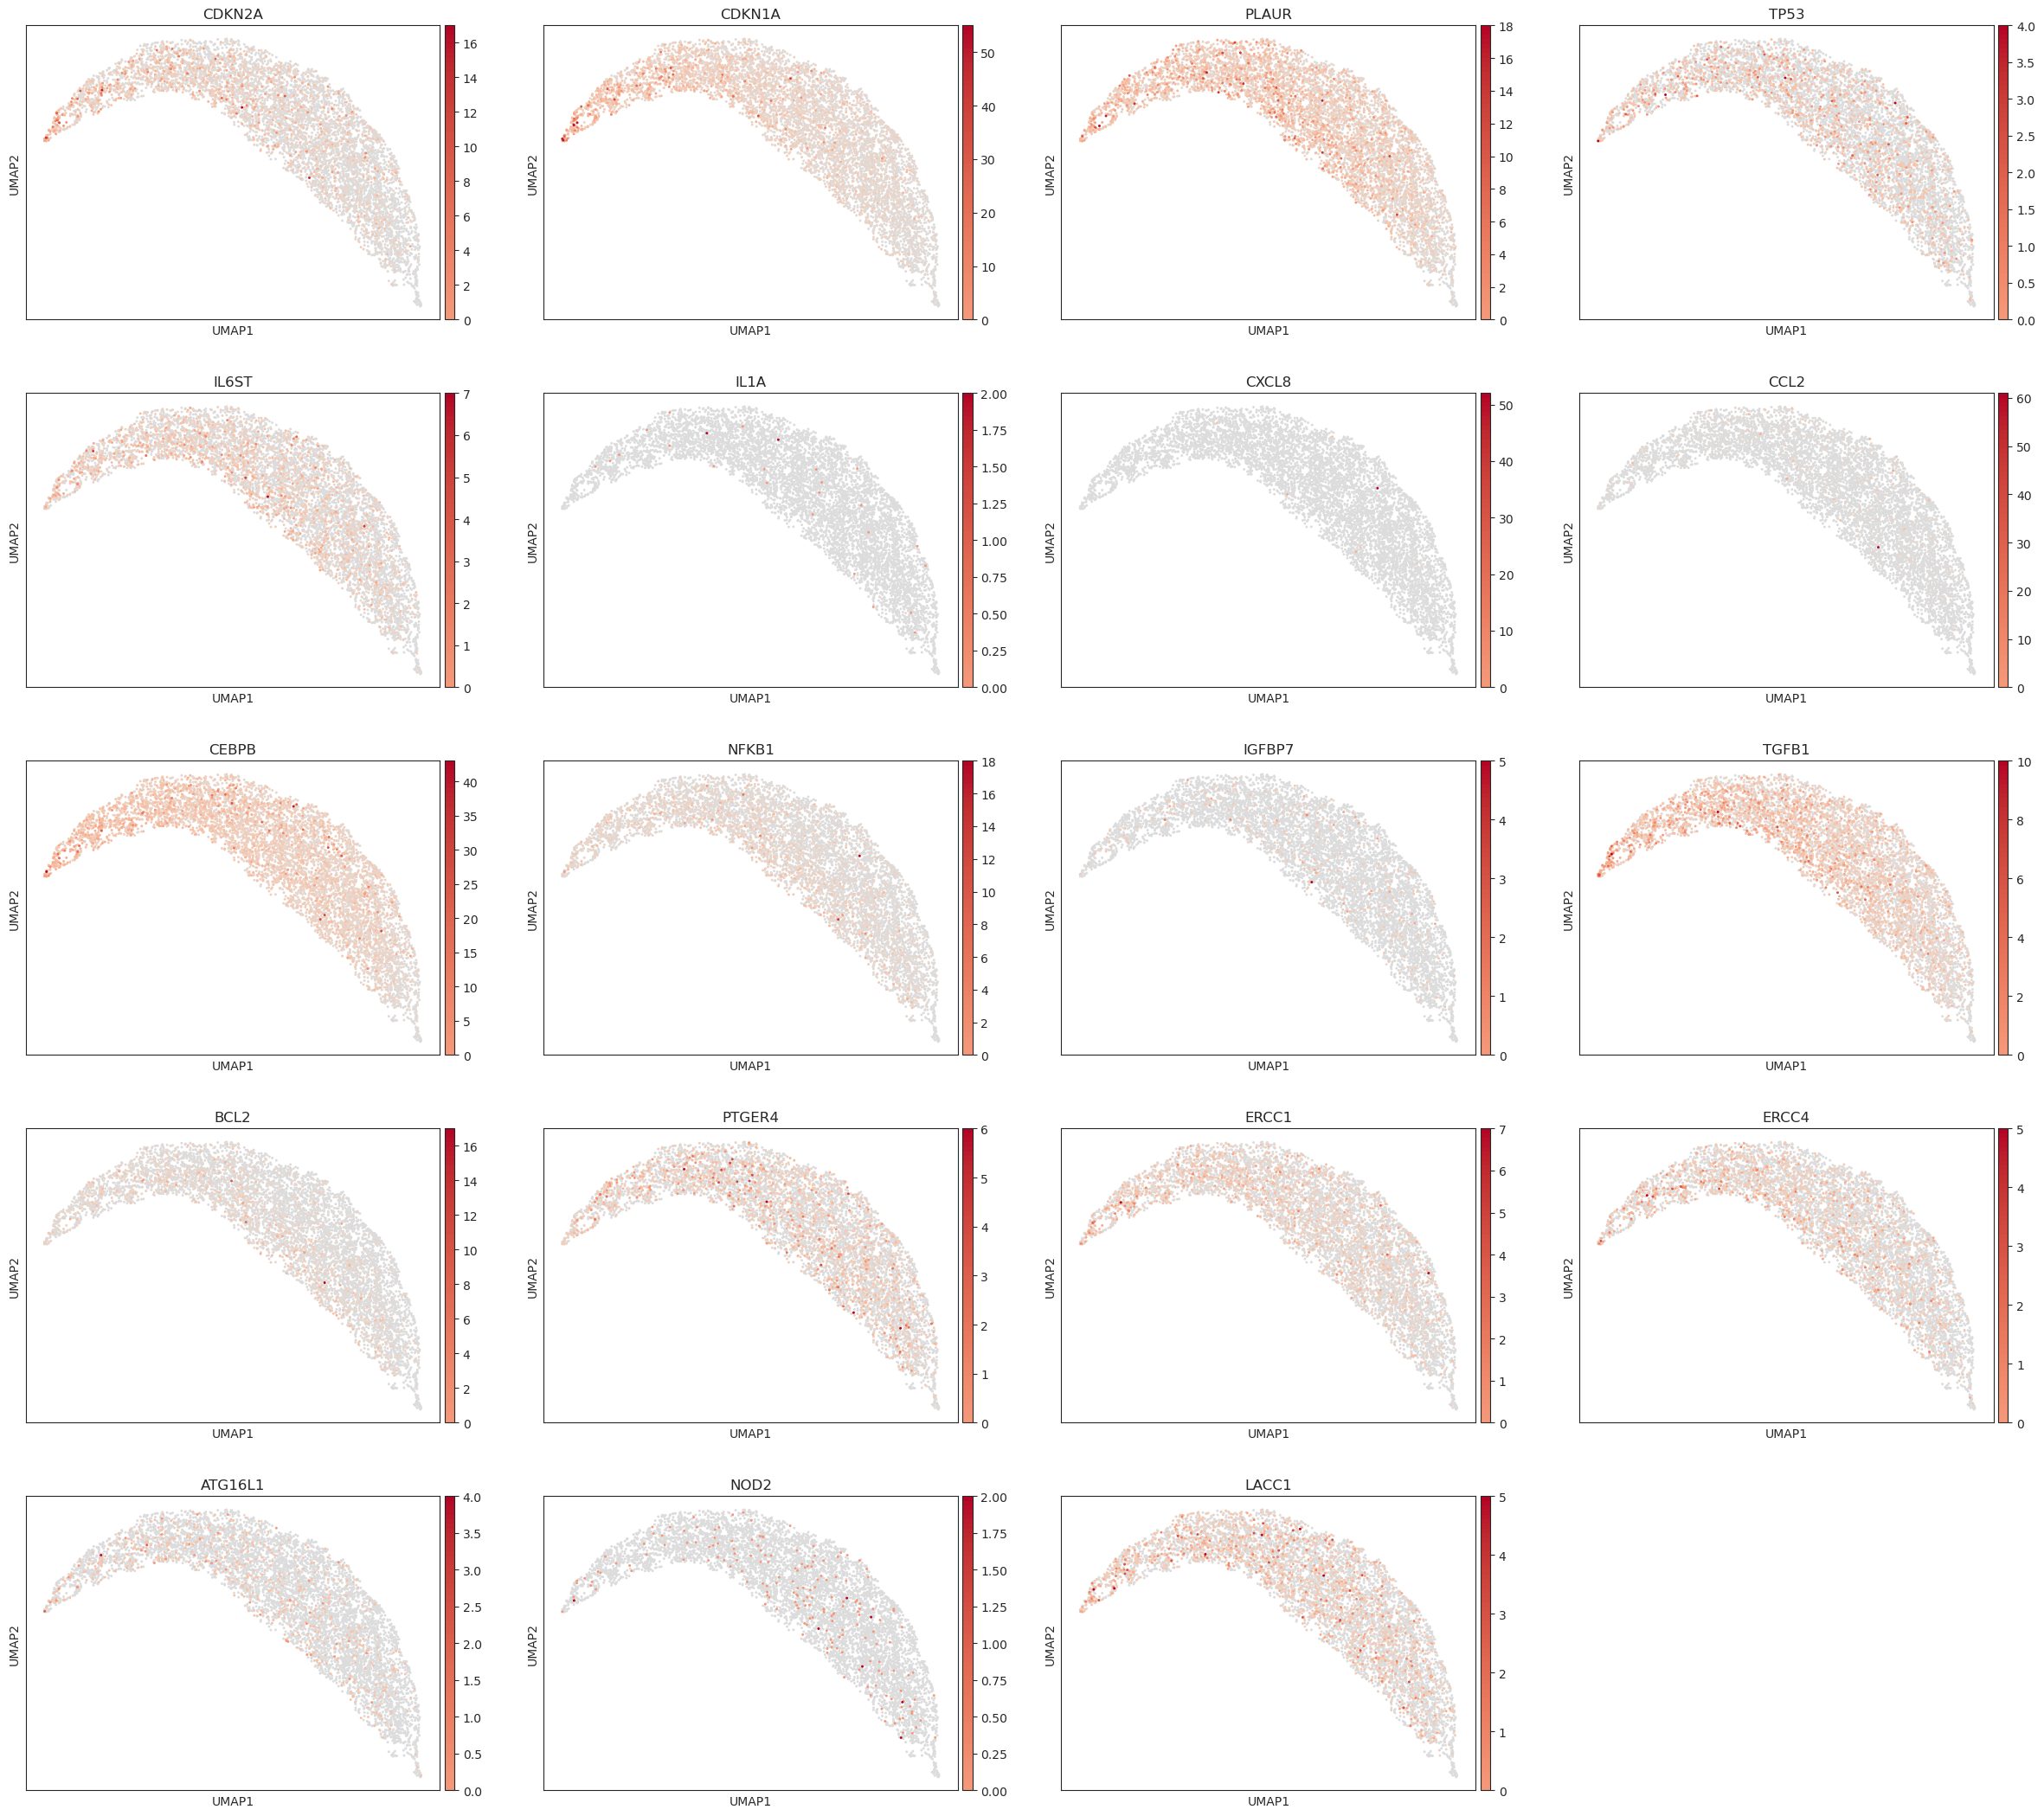

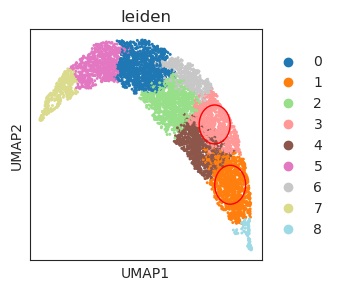

In [7]:
figs = self.plot(genes=genes_subset, 
                 layers="all",  # also plot "scaled" layer, for instance
                 cell_types_circle=["3", "1"],  # circle particular cell types on UMAP
                 genes_highlight=list(np.array(genes_subset)[1:3]), 
                 kws_gex_violin=dict(scale="area", height=10),
                 kws_clustering=dict(col_cell_type="leiden"))

# Perturbation Analyses

## Guide RNAs

### Guide RNA Counts/Percentage

In [ ]:
tgis = list(pd.Series(target_gene_idents).sample(3)) if len(
    target_gene_idents) > 3 else target_gene_idents  # smaller subset for speed
self.get_guide_rna_counts(target_gene_idents=tgis)
self.get_guide_rna_counts(target_gene_idents=tgis, 
                          group_by=True)  # by cell type
self.get_guide_rna_counts(target_gene_idents=tgis, group_by=[
    self._columns["col_cell_type"], self._columns["col_target_genes"]], 
                          margin_titles=True)
self.get_guide_rna_counts(target_gene_idents=tgis, group_by=[
    self._columns["col_target_genes"]], margin_titles=True)

### Targeting Efficiency

## Augur: Cell Type-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type
- Identify the most important features (genes).

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

AnnData object with n_obs × n_vars = 6733 × 22024
    obs: 'num_features', 'feature_call_original', 'num_umis_original', 'feature_call', 'feature_call_flat_ix', 'feature_call_list_all', 'num_umis_list_all', 'num_umis_total', 'feature_call_list_filtered', 'num_umis_list_filtered', 'feature_call_filtered', 'num_umis_filtered', 'feature_split', 'num_umis', 'target_gene_name', 'perturbation', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'label', 'cell_type'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


Filtering samples with NT and KD labels.

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Skipping 7 cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping 8 cell type - the number of samples for at least one class type is less than subsample size 20.

                         2         0         3         4         1         5  \
mean_augur_score  0.484490  0.498753  0.501349  0.525454  0.494717  0.528583   
mean_auc          0.484490  0.498753  0.501349  0.525454  0.494717  0.528583   
mean_accuracy     0.483993  0.497363  0.504396  0.499267  0.487399  0.512601   
mean_precision    0.484222  0.502722  0.514021  0.489968  0.483821  0.516264   
mean_f1           0.446573  0.434024  0.486833  0.443469  0.419196  0.480811   
mean_recall       0.467937  0.427619  0.513492  0.454444  0.420635  0.505079   

                         6  
mean_augur_score  0.482018  
mean_auc          0.482018  
mean_accuracy     0.486190  
mean_precision    0.489579  
mean_f1           0.445696  
mean_recall       0.456190  


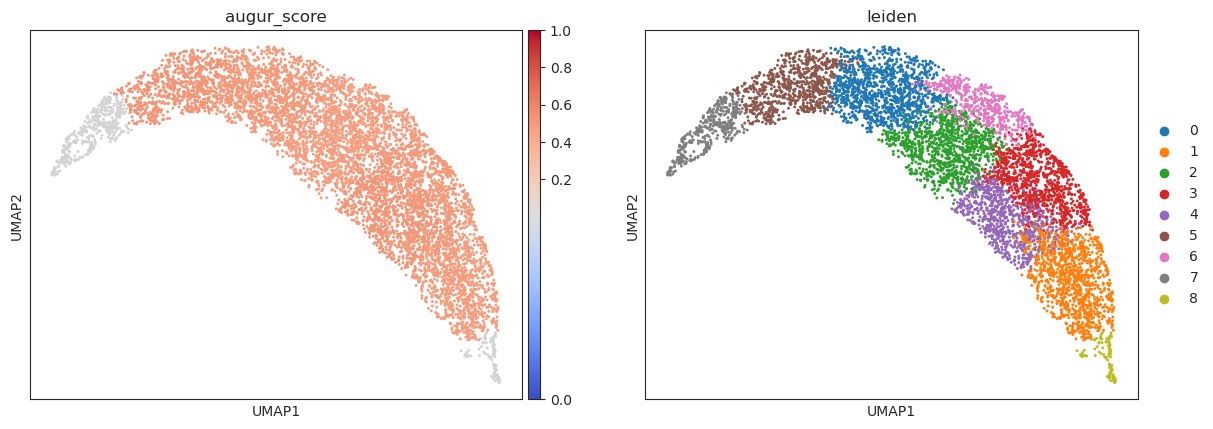

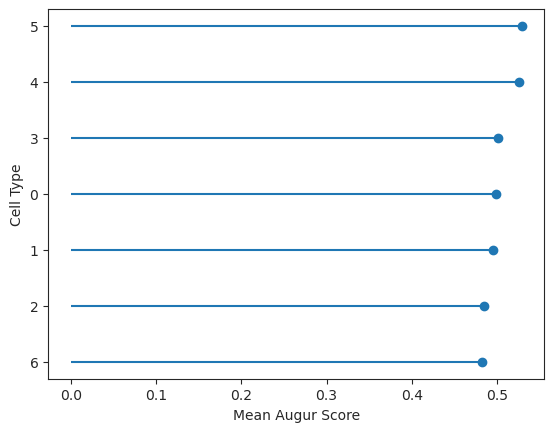

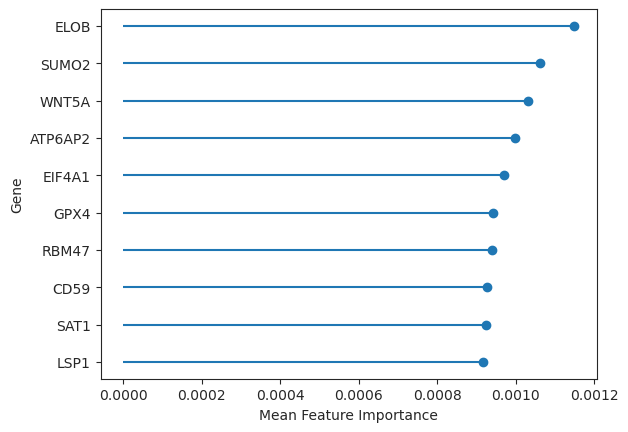

In [6]:
augur_data, augur_results, figs_augur = self.run_augur(
    col_perturbation=self._columns["col_perturbation"], 
    key_treatment=self._keys["key_treatment"], 
    classifier="random_forest_classifier", n_threads=True,
    augur_mode="default", select_variance_features=True, 
    n_folds=2,  # in real life, you'll want this to be >= 3, usually 3-10
    kws_umap=kws_umap, subsample_size=20, 
    kws_augur_predict=dict(span=0.7))

## Mixscape: Cell-Level Perturbation Response

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]``), you can specify a different column by passing `col_cell_type=<column name>` if you'd like.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. True to include all.

<u> __Output__ </u>  
- Mixscape figures

<u> __Notes__ </u>  


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_num_umis': 'num_umis', 'key_nonperturbed': 'NP'}


Target gene STK11 not in mixscape_class!


Target gene IRF8 not in mixscape_class!


Target gene INPP5D not in mixscape_class!


Target gene RASGRP1 not in mixscape_class!


Target gene IL10RB not in mixscape_class!


Target gene IL6ST not in mixscape_class!


Target gene TAGAP not in mixscape_class!


Target gene RPN1 not in mixscape_class!


Target gene SP110 not in mixscape_class!


Target gene MYD88 not in mixscape_class!


Target gene CSF1R not in mixscape_class!


Target gene GPX4 not in mixscape_class!


Target gene PPM1G not in mixscape_class!


Target gene PDPN not in mixscape_class!


Target gene WSB1 not in mixscape_class!


Target gene PTPN22 not in mixscape_class!


Target gene RIPK2 not in mixscape_class!


Target gene FASLG not in mixscape_class!


Target gene PAF1 not in mixscape_cla

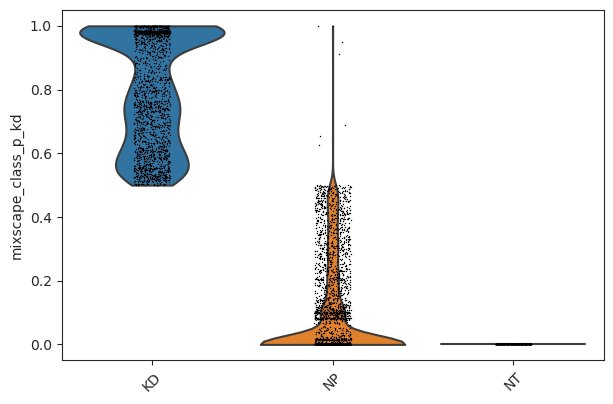

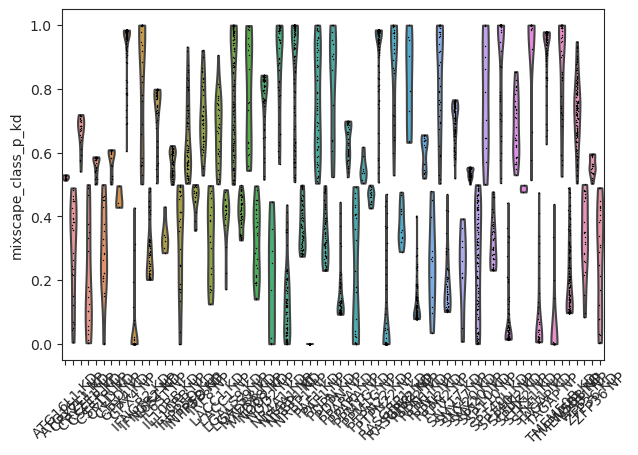

In [12]:
figs_mixscape = self.run_mixscape(col_split_by=col_split_by,
                                  target_gene_idents=True  
                                  # or specify list of genes of interest
                                  )

## Distance Metrics

See `self.figures[run_label]["distances"]` and  `self.results[run_label]["distances"]`
for results.


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}


Output()

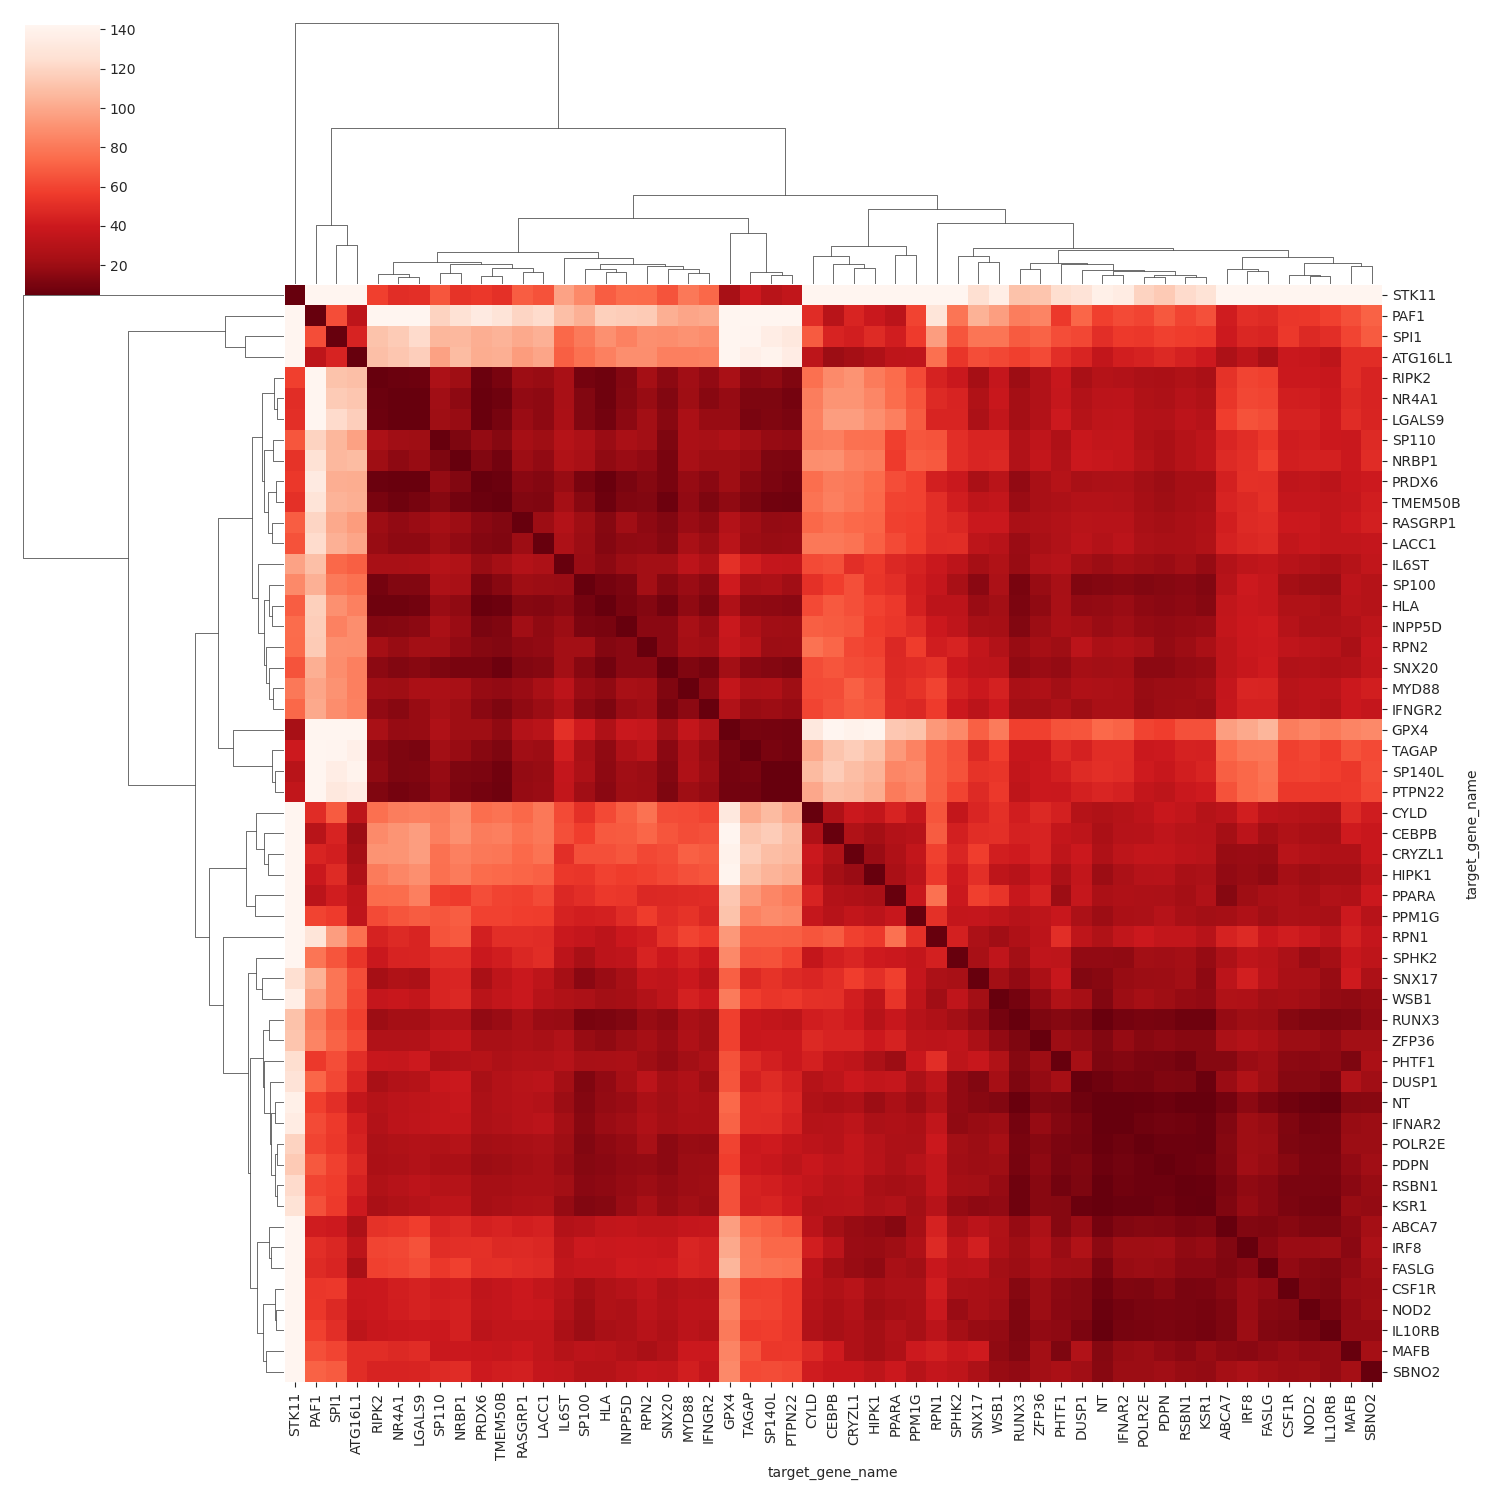

Output()

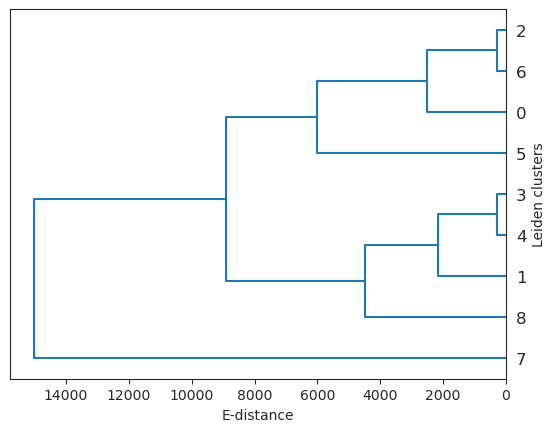

Output()


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}


<Figure size 640x480 with 0 Axes>

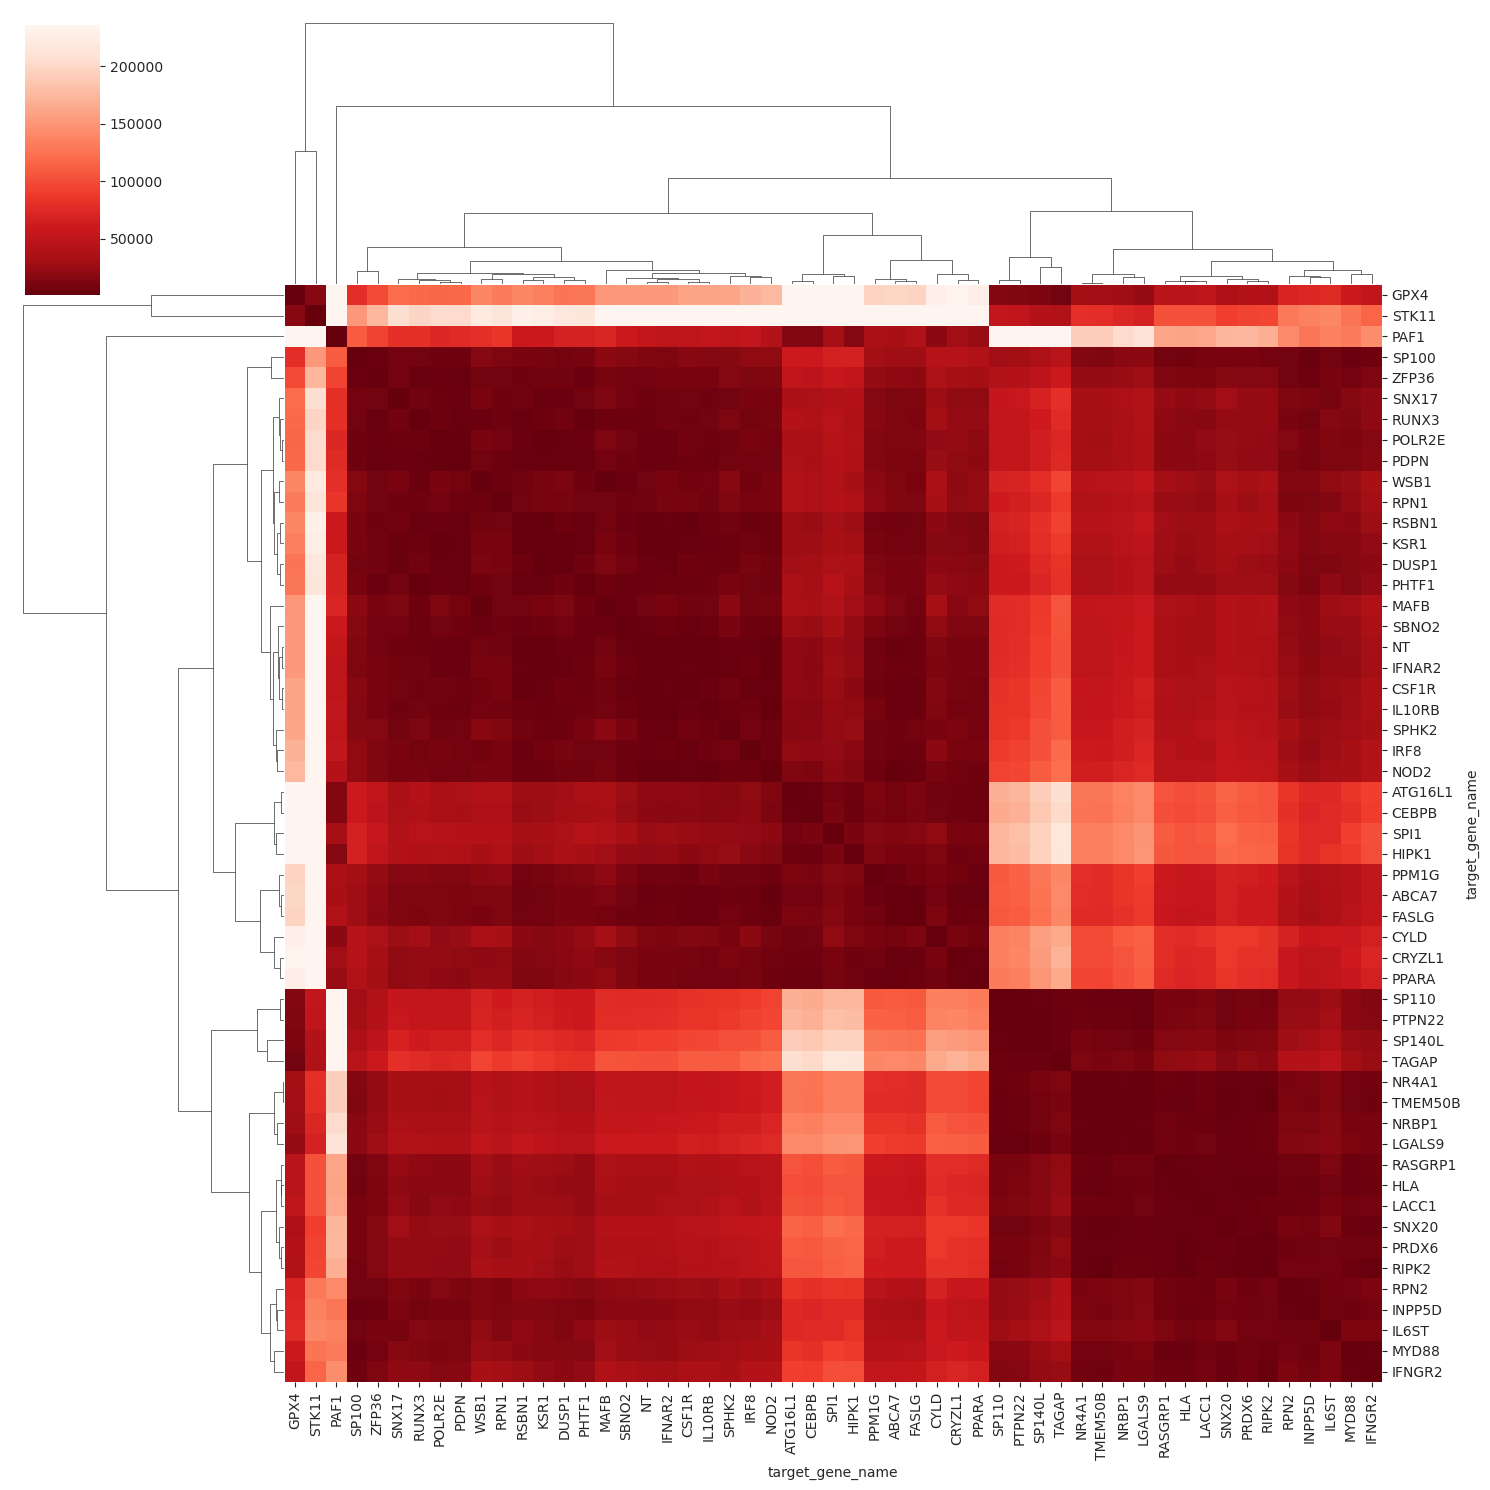

Output()

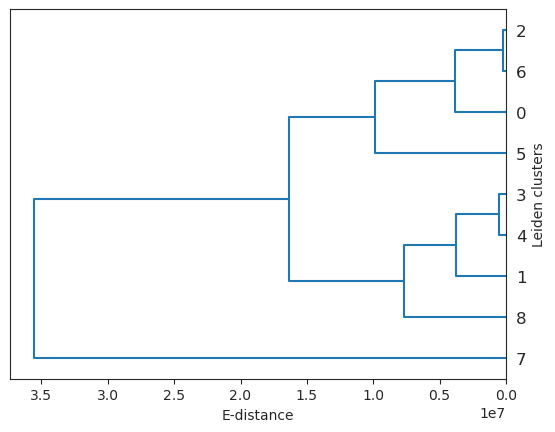

<Figure size 640x480 with 0 Axes>

In [7]:
fig_dist_w = self.compute_distance(distance_type="edistance", method="X_pca",
                                   kws_plot=dict(figsize=(15, 15), robust=True))

fig_dist_e = self.compute_distance(distance_type="mmd", method="X_pca",
                                   kws_plot=dict(figsize=(15, 15), robust=True))

## Composition Analysis

In [14]:
try:
    oca = self.run_composition_analysis(
        "0", est_fdr=0.05, generate_sample_level=False)
except Exception as err:
    print(f"{err}\n\n\nComposition analysis failed!")


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': None, 'col_batch': None, 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'col_target_genes': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}
'NoneType' object has no attribute 'astype'


Composition analysis failed!


## Dialogue: Multi-Cellular Programs

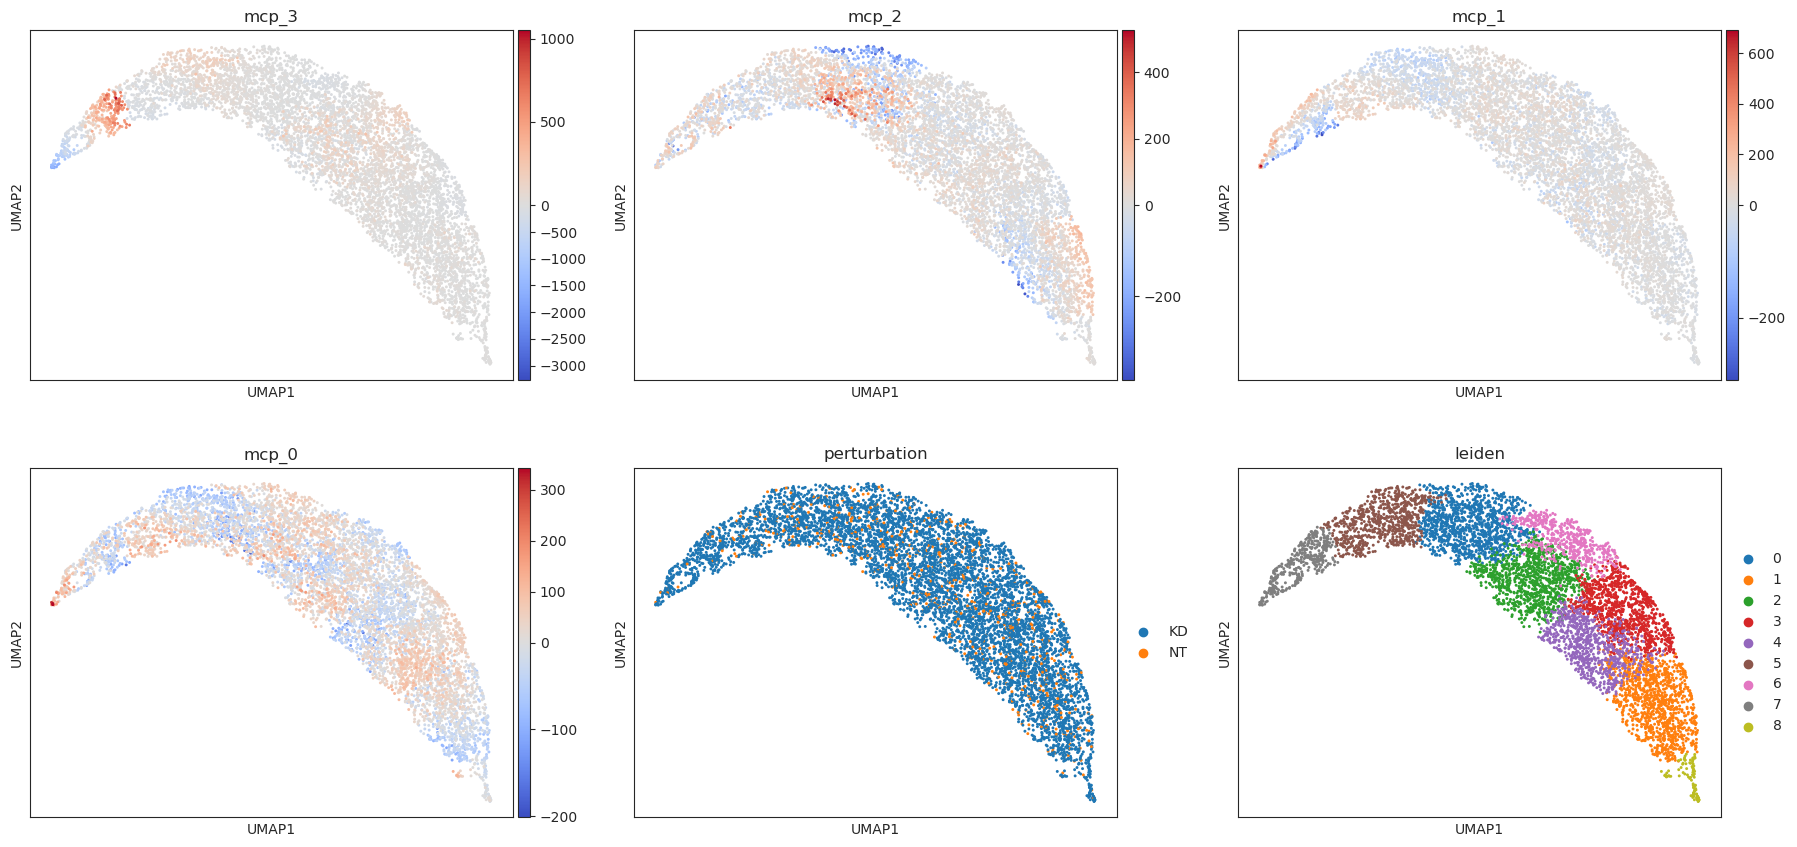

In [15]:
fig_mcp = self.run_dialogue(n_programs=4, cmap="coolwarm")

# Random Workspace (IGNORE)

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pl.umap(self.adata, color="CDKN1A", palette="coolwarm", legend_loc="on_data", show=False)
a_x = plt.gca()
for cluster in self.adata.obs[col_cell_type].unique():
    cmu = self.adata[col_cell_type == cluster].obsm["X_umap"].mean(axis=0)
    a_x.annotate(cluster, cmu, fontsize=8, color="black", weight="bold", ha="center")
plt.show()


for ax in figs["clustering_gene_expression"].axes:
    for cluster in self.adata.obs[col_cell_type].unique():
        cmu = self.adata[col_cell_type == cluster].obsm["X_umap"].mean(axis=0)
        ax.annotate(cluster, cmu, fontsize=8, color="black", weight="bold", ha="center")

In [ ]:
import crispr as cr
import numpy as np

file = "/home/asline01/projects/crispr/examples/data/adamson_2016_upr_perturb_seq.h5ad"
kwargs_init = {
    "assay": None, "assay_protein": None, "col_cell_type": "celltype",
    "col_gene_symbols": "gene_symbol", "col_sample_id": None, 
    "col_batch": None, "col_perturbation": "perturbation", 
    "col_guide_rna": "perturbation", "col_num_umis": "UMI count", 
    "kws_process_guide_rna": dict(
        feature_split=None, guide_split="_", key_control_patterns=[np.nan]), 
    "col_target_genes": "perturbation", "key_control": "Control", 
    "key_treatment": "KO", "remove_multi_transfected": True}
for q in [kwargs_init, kwargs_init["kws_process_guide_rna"]]:
    cr.tl.print_pretty_dictionary(q)
adata = cr.pp.create_object(file, **kwargs_init)

ann = adata.copy()

assay=np.nan
assay_protein=np.nan
col_cell_type='celltype'
col_gene_symbols='gene_symbol'
col_sample_id=np.nan
col_batch=np.nan
col_perturbation='perturbation'
col_guide_rna='perturbation'
col_num_umis='UMI count'
kws_process_guide_rna=dict(feature_split = np.nan, guide_split = '_', key_control_patterns = [np.nan])
col_target_genes='perturbation'
key_control='Control'
key_treatment='KO'
remove_multi_transfected=True
feature_split=np.nan
guide_split='_'
key_control_patterns=[np.nan]
max_percent_umis_control_drop=75
min_percent_umis=40

feature_split = "|"
if ann.obs[col_guide_rna].apply(lambda x: feature_split in x).any():
    raise ValueError(
        f"""For single-guide designs, the character {feature_split}
        cannot be found in any of the guide names ({col_guide_rna})""")
tg_info = cr.pp.find_guide_info(
    ann.copy(), col_guide_rna, col_num_umis=col_num_umis, 
    feature_split=feature_split, guide_split=guide_split, 
    key_control_patterns=key_control_patterns, 
    key_control=key_control)



out = cr.pp.filter_by_guide_counts(
    adata, kwargs_init["col_guide_rna"], kwargs_init["col_num_umis"],
    max_percent_umis_control_drop=75,
    min_percent_umis=40, **kwargs_init["kws_process_guide_rna"], 
    key_control="Control")